# VBM Analysis
1. Analysis of VBM itself
2. VBM alignment against attributes: Attributes (.npy) brain vs. Alignment files (all_clusters.nii)

In [1]:
from alignment_overlap import get_masked_topq, compare_brain_maps
from metadata import load_vbm, load_vbm_adni, load_vbm_overlap
import constants as C_
import weight_parser as wp

In [2]:
%cd ..

import json

import numpy as np
import nibabel as nib
import nilearn.image as nili
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import sage
import sage.constants as C
import sage.xai.nilearn_plots as nilp_
import sage.xai.utils as utils

brain_mask = C.load_mni152_brain_mask()
qs = [0.1, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 25, 50]

/home/daehyun/.conda/envs/age/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/daehyun/codespace/brain-age-prediction


## Overlapping regions sanity check

### Checking Top-q values from array

In [32]:
attr = np.load("/home/daehyun/codespace/brain-age-prediction/meta_brain/weights/default/convnext-base-43/ggcamk0.99/attrs.npy")
attr = np.load("/home/daehyun/codespace/brain-age-prediction/meta_brain/weights/default/convnext-base-43/deepliftk0.99/attrs.npy")

In [46]:
# Weighted Dice function
def weighted_dice_score(pred, target, target_map):
    pred = pred.astype(np.float32)
    target = target.astype(np.float32)
    target_map = target_map.astype(np.float32)
    
    # Normalize target_map to [0, 1]
    norm_target_map = (target_map - np.min(target_map)) / (np.max(target_map) - np.min(target_map) + 1e-8)
    
    intersection = np.sum(norm_target_map * pred * target)
    pred_sum = np.sum(norm_target_map * pred)
    target_sum = np.sum(norm_target_map * target)
    
    dice = (2.0 * intersection) / (pred_sum + target_sum + 1e-8)
    return dice


def weighted_dice_score_both(pred, target, gt_weight, pred_weight):
    """
    Compute weighted Dice coefficient using separate weights for both ground truth and prediction.
    
    Args:
        pred (np.ndarray): Prediction mask or continuous prediction map.
        target (np.ndarray): Ground truth mask.
        gt_weight (np.ndarray): Weight map associated with the ground truth.
        pred_weight (np.ndarray): Weight map associated with the prediction.
    
    Returns:
        float: Weighted Dice coefficient.
    """
    import numpy as np
    
    # Convert inputs to float32 for numerical stability
    pred = pred.astype(np.float32)
    target = target.astype(np.float32)
    gt_weight = gt_weight.astype(np.float32)
    pred_weight = pred_weight.astype(np.float32)
    
    # Normalize the weight maps to [0, 1] to avoid overly large contributions
    norm_gt_weight = (gt_weight - np.min(gt_weight)) / (np.max(gt_weight) - np.min(gt_weight) + 1e-8)
    norm_pred_weight = (pred_weight - np.min(pred_weight)) / (np.max(pred_weight) - np.min(pred_weight) + 1e-8)
    
    # Compute the weighted intersection and sums
    intersection = np.sum(norm_gt_weight * norm_pred_weight * pred * target)
    target_sum = np.sum(norm_gt_weight * target)
    pred_sum = np.sum(norm_pred_weight * pred)
    
    dice = (2.0 * intersection) / (target_sum + pred_sum + 1e-8)
    return dice

In [29]:
target_map = vbm_merge.copy()

masked_target = target_map * brain_mask.get_fdata()
target_nonzero = (masked_target != 0)

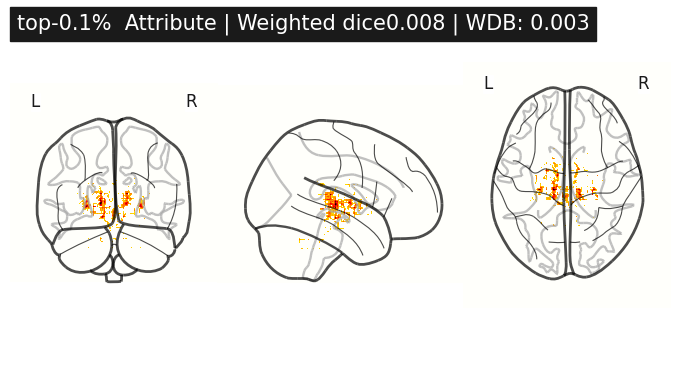

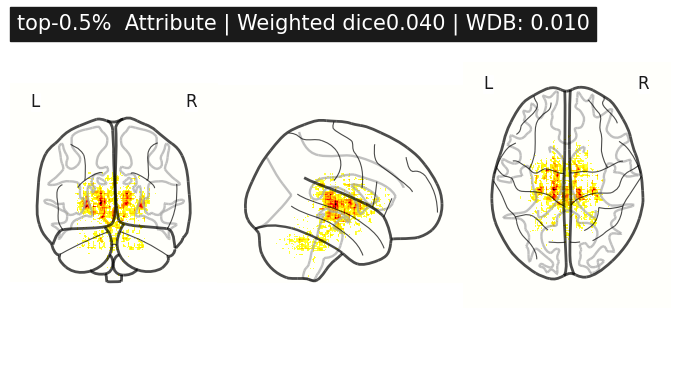

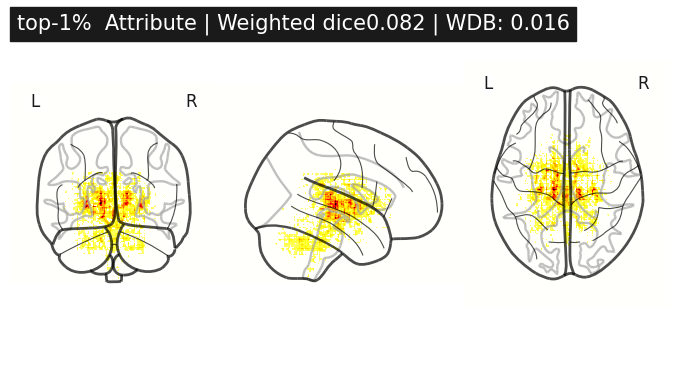

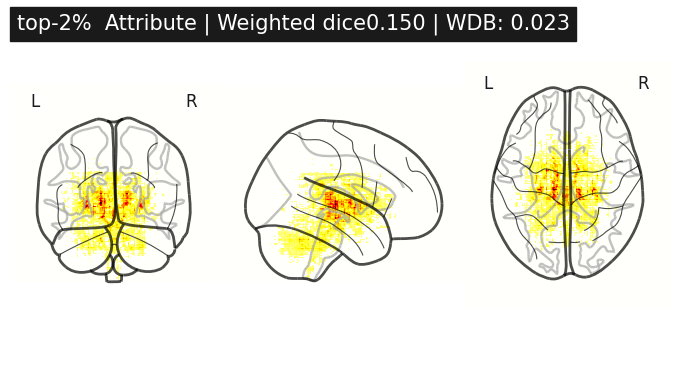

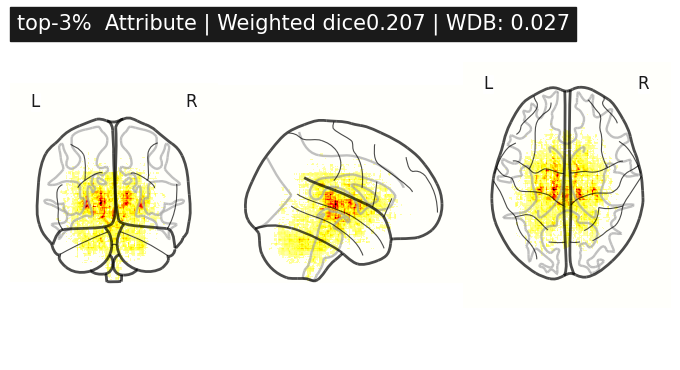

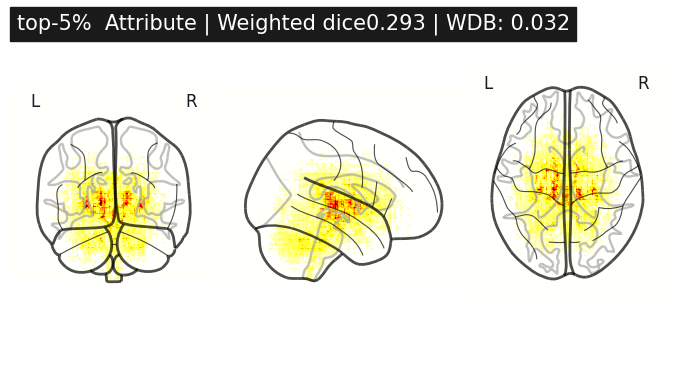

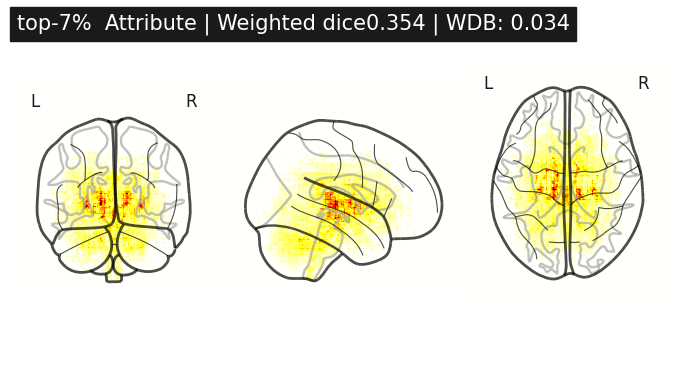

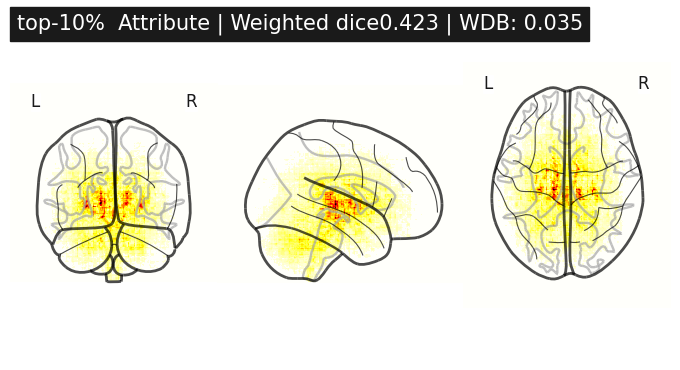

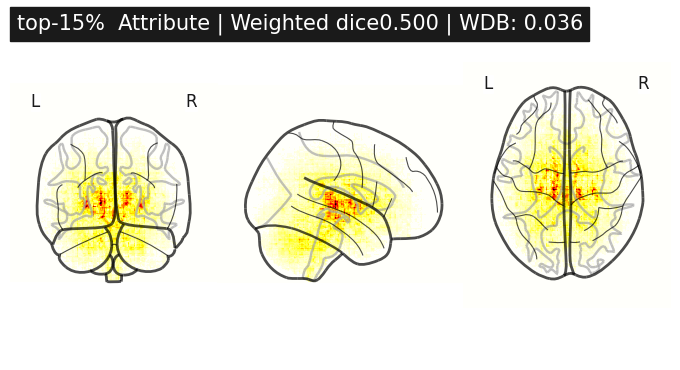

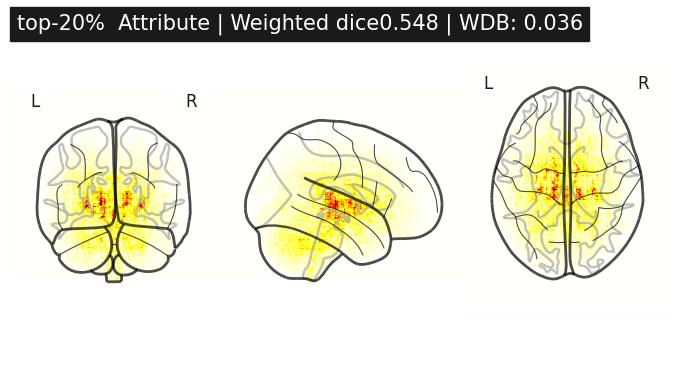

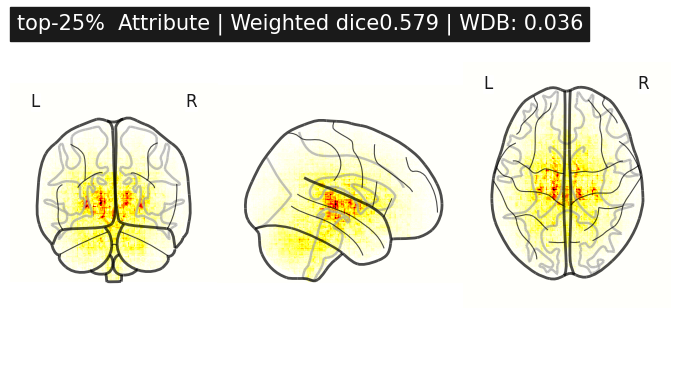

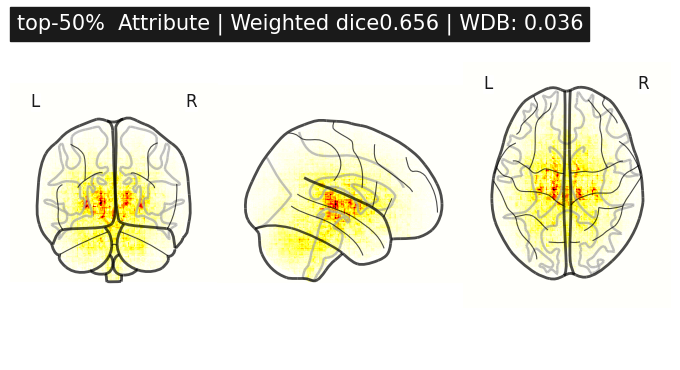

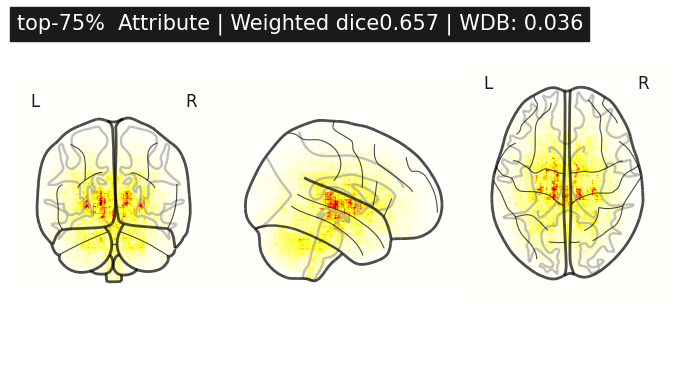

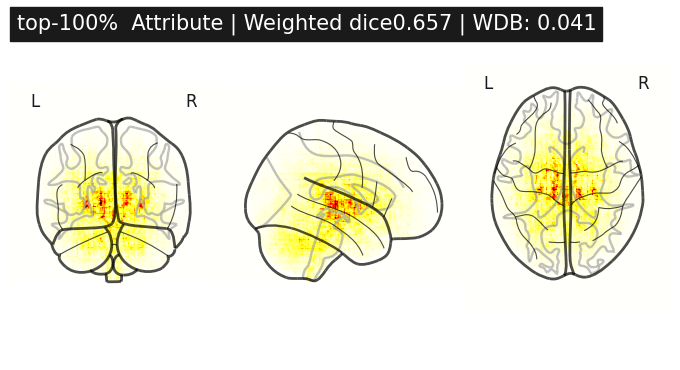

In [47]:
# brain_mask = brain_mask.get_fdata()

masked_saliency = attr * brain_mask
brain_voxels = brain_mask > 0

for q in qs + [75, 100]:
    brain_saliency = masked_saliency[brain_voxels]
    nonzero_saliency = brain_saliency[brain_saliency != 0]
    saliency_threshold = np.percentile(nonzero_saliency, 100 - q) if len(nonzero_saliency) > 0 else 0
    
    # Create binary mask for current threshold
    current_saliency_mask = (masked_saliency >= saliency_threshold) & (masked_saliency > 0)
    current_saliency = (masked_saliency >= saliency_threshold) * masked_saliency
    # attrs_top = get_masked_topq(attr, mask=brain_mask, q_percentile=q)
    # attrs_top_nii = utils._nifti(attrs_top, affine=C.BIOBANK_AFFINE)
    
    wd = weighted_dice_score(pred=current_saliency_mask,
                             target=target_nonzero,
                             target_map=masked_target)
    
    wdb = weighted_dice_score_both(pred=current_saliency_mask,
                                   target=target_nonzero,
                                   gt_weight=masked_target,
                                   pred_weight=current_saliency)
    nilp_.plot_glass_brain(current_saliency_mask * attr, title=f"top-{q}%  Attribute | Weighted dice{wd:.3f} | WDB: {wdb:.3f}")

### Find overlap between merged

In [4]:
attr_q = get_masked_topq(brain=attr, mask=brain_mask, q_percentile=1)
overlap_bool = np.logical_and(vbm_merge.get_fdata(), attr_q) * brain_mask.get_fdata()
overlap_val = overlap_bool * vbm_merge.get_fdata()
nilp_.plot_overlay(overlap_val, target_affine=affine, colorbar=True)

NameError: name 'attr' is not defined

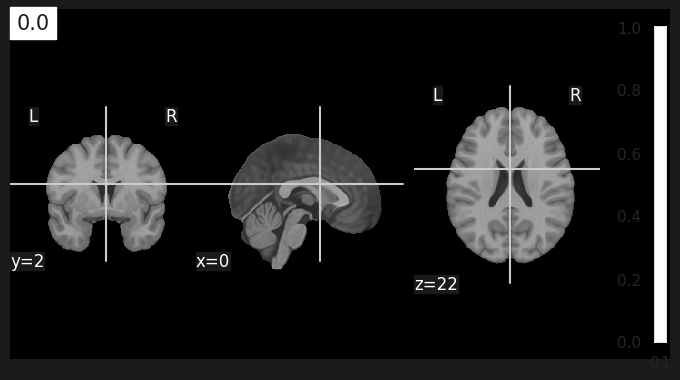

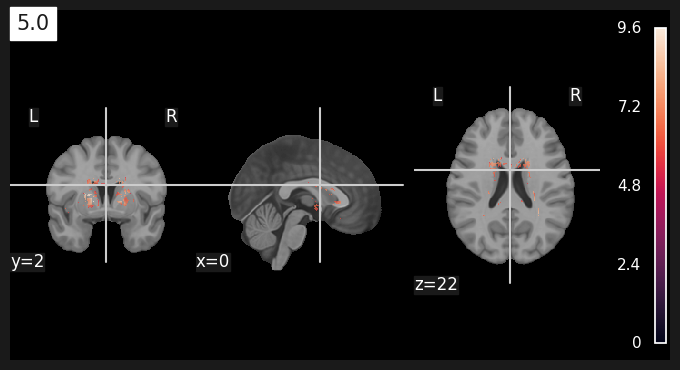

In [11]:
qs, qs_percentile = [], []
for q in np.linspace(0, 5, 100):
    attr_q = get_masked_topq(brain=attrs, mask=brain_mask, q_percentile=q)
    overlap_bool = np.logical_and(vbm_merge.get_fdata(), attr_q) * brain_mask.get_fdata()
    overlap_val = overlap_bool * vbm_merge.get_fdata()

    qs.append(overlap_bool.sum())
    qs_percentile.append(overlap_bool.sum() / len(np.nonzero(attr_q)[0]))
    if np.isclose(q, round(q)):
        nilp_.plot_overlay(overlap_val, target_affine=affine, colorbar=True, title=q)

## Check Calculated Overlaps

In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.power import FTestAnovaPower
from statsmodels.formula.api import ols


qs = [0.1, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 25, 50, 75, 100]

Load VBM overlapping results

In [ ]:
attrs, tattrs = load_vbm_overlap(n_jobs=8)
attrs_adni, tattrs_adni = load_vbm_overlap(n_jobs=8, use_adni=True)

Primary config directory not found.
Check that the config directory '/home/daehyun/codespace/brain-age-prediction/RQ/meta_brain/weights/default/resnet10-44/.hydra' exists and readable
Primary config directory not found.
Check that the config directory '/home/daehyun/codespace/brain-age-prediction/RQ/meta_brain/weights/default/resnet10-43/.hydra' exists and readable
Primary config directory not found.
Check that the config directory '/home/daehyun/codespace/brain-age-prediction/RQ/meta_brain/weights/default/resnet10-42/.hydra' exists and readable
Primary config directory not found.
Check that the config directory '/home/daehyun/codespace/brain-age-prediction/RQ/meta_brain/weights/default/resnet10-48/.hydra' exists and readable
Primary config directory not found.
Check that the config directory '/home/daehyun/codespace/brain-age-prediction/RQ/meta_brain/weights/default/resnet10-46/.hydra' exists and readable
Primary config directory not found.
Check that the config directory '/home/daehy

### Plot Overlap Metrics

In [ ]:
def parse(s):
    s_ = s.split("|")
    if len(s_) > 3:
        xai = "_".join(s_[:-2])
        model_name, seed = s[-2:]
    elif len(s_) < 3:
        raise
    else:
        xai, model_name, seed = s_
    return xai, model_name, seed

keys_ukb = [parse(s) for s in list(attrs.keys())]
keys_adni = [parse(s) for s in list(attrs_adni.keys())]

In [9]:
keys = [parse(s) for s in list(attrs.keys())]
keys = pd.DataFrame(keys, columns=["XAI", "Model", "Seed"])

metric = "dice"
# vals = [max(attrs[s][metric]) for s in list(attrs.keys())]
vals = [attrs[s][metric][5] for s in list(attrs.keys())] # q=10%
# vals = [qs[np.argmax(attrs[s][metric])] for s in list(attrs.keys())] # argmax
df = keys.copy()
df[metric] = vals

In [ ]:
def create_df_across_qs(attr: dict, metric: str = "dice", stats_verbose: bool = False):
    keys = [parse(s) for s in list(attr.keys())]
    keys = pd.DataFrame(keys, columns=["XAI", "Model", "Seed"])

    q_df = []
    for i, q in enumerate(qs + [75, 100]):
        vals = [attr[s][metric][i] for s in list(attr.keys())] # argmax
        df = keys.copy()
        df[metric] = vals
        
        if stats_verbose:
            print(f"q={q}")
            condition = f"{metric} ~ XAI*Model"
            model = ols(condition, data=df).fit()
            anova_table = sm.stats.anova_lm(model, type=2)
            print(anova_table)

        df["q"] = q
        q_df.append(df)
    q_df = pd.concat(q_df)
    q_df = q_df.replace(to_replace=C_.XAI_METHODS_MAPPER)
    return q_df

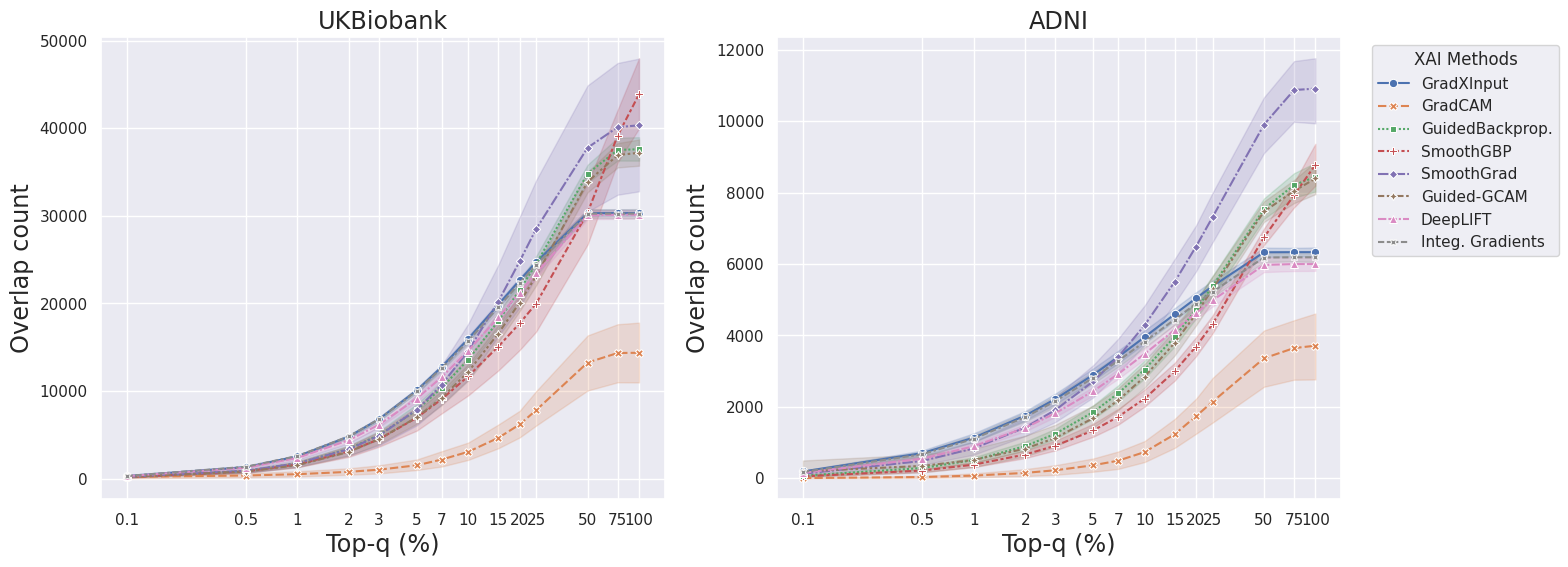

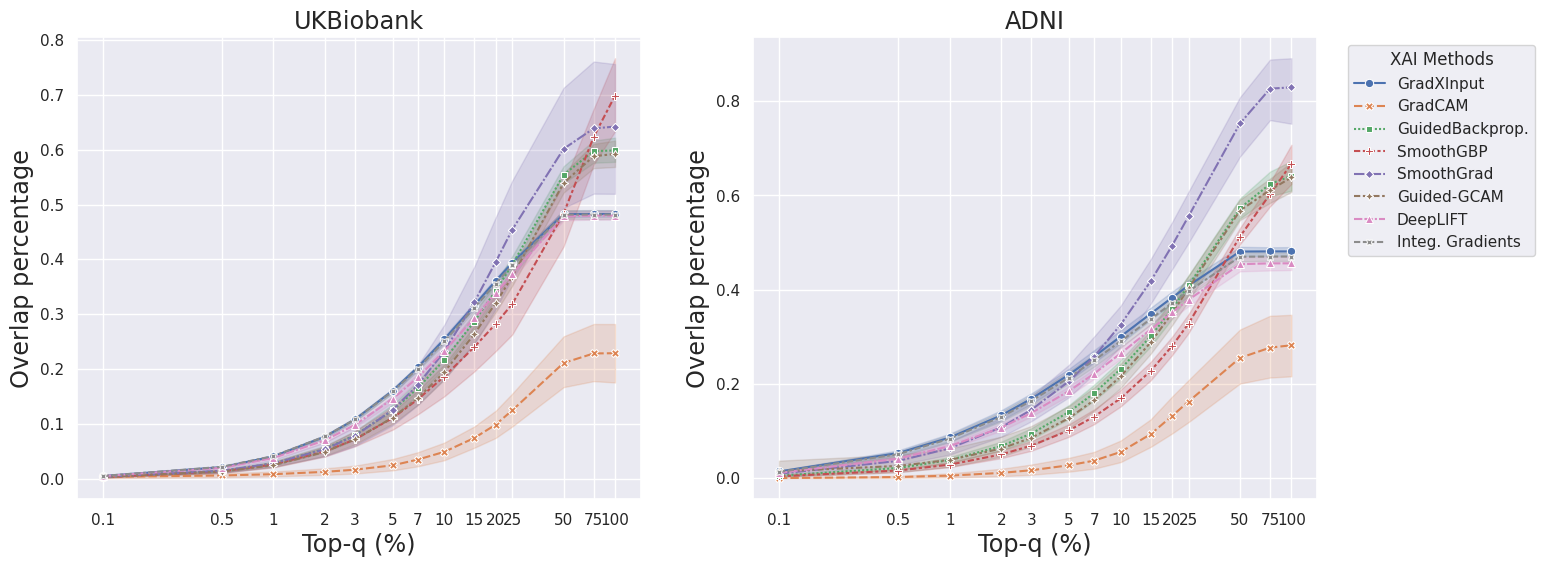

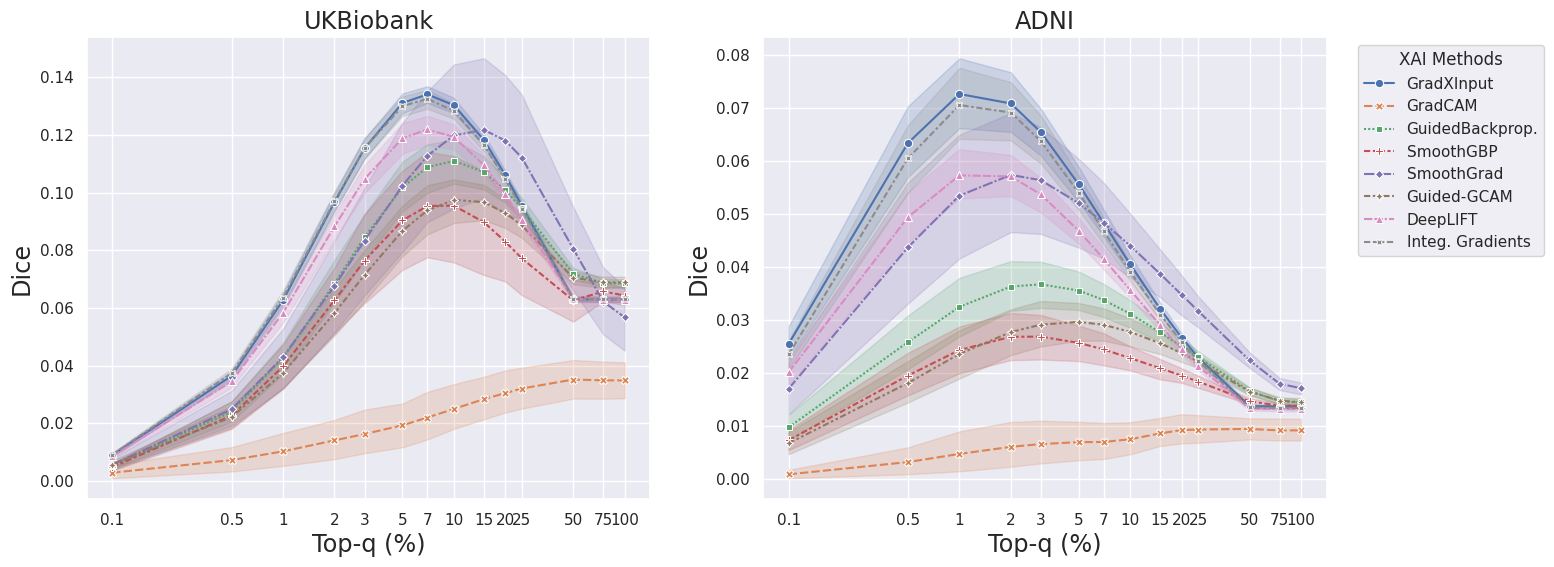

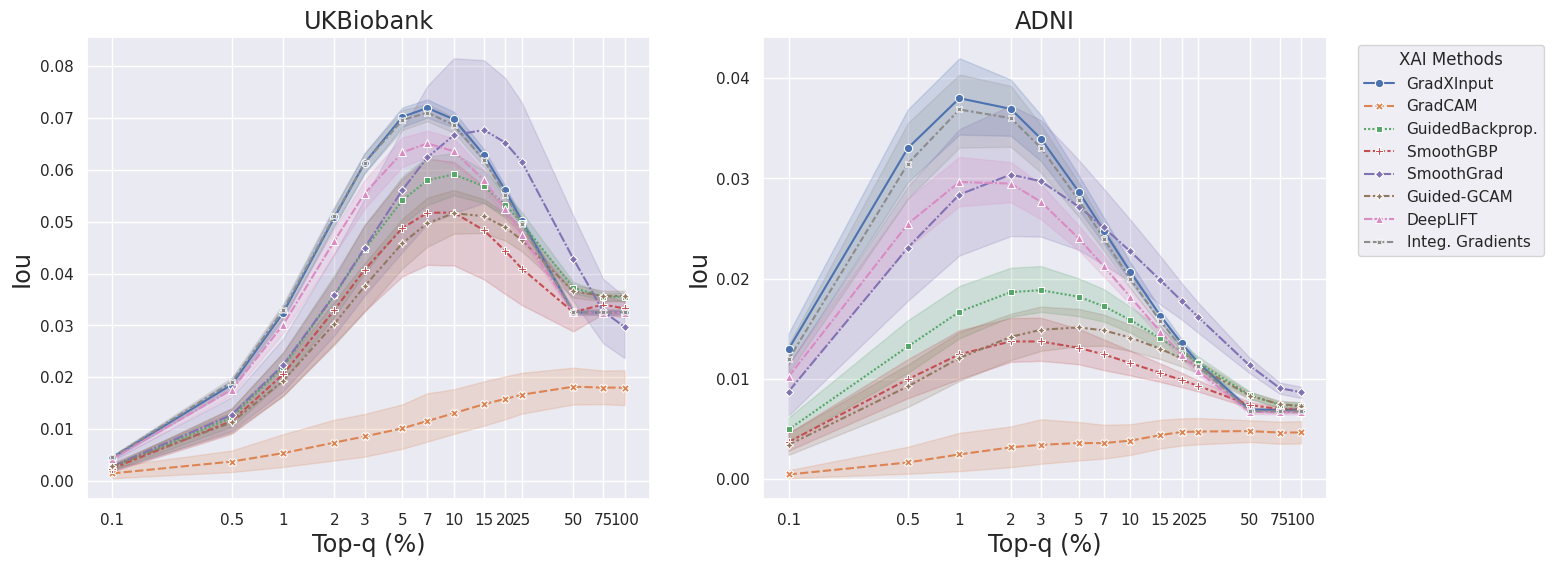

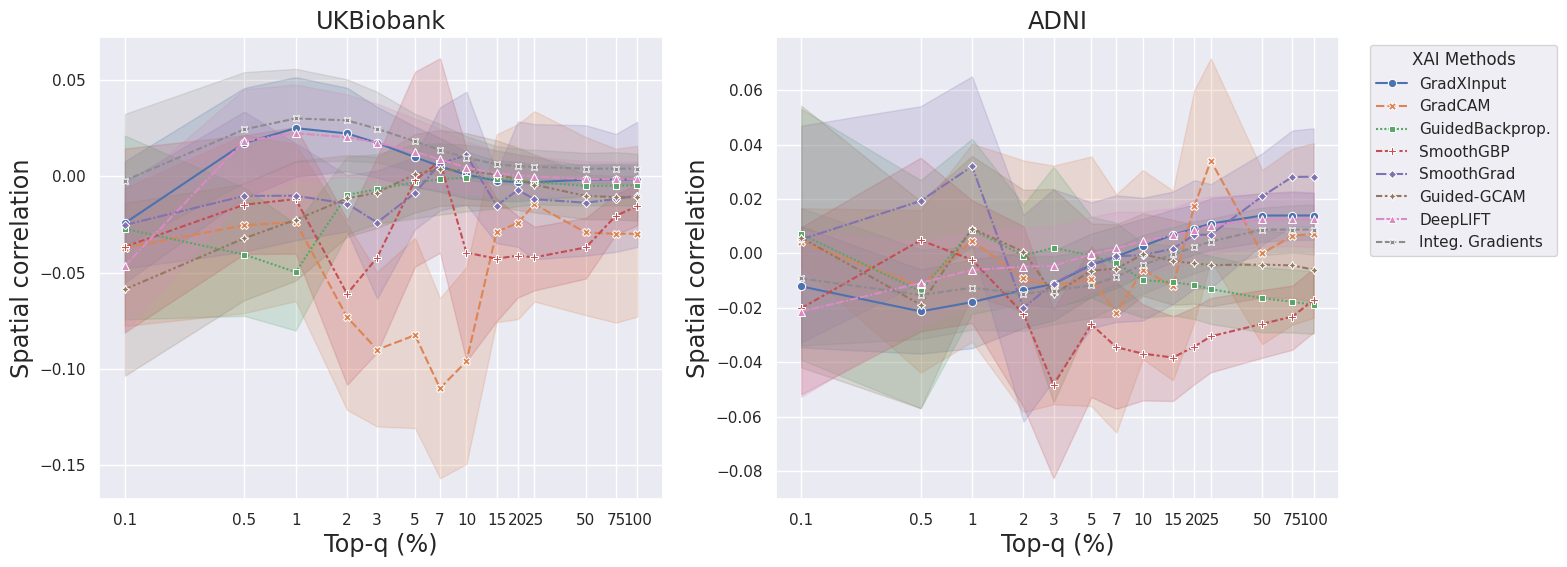

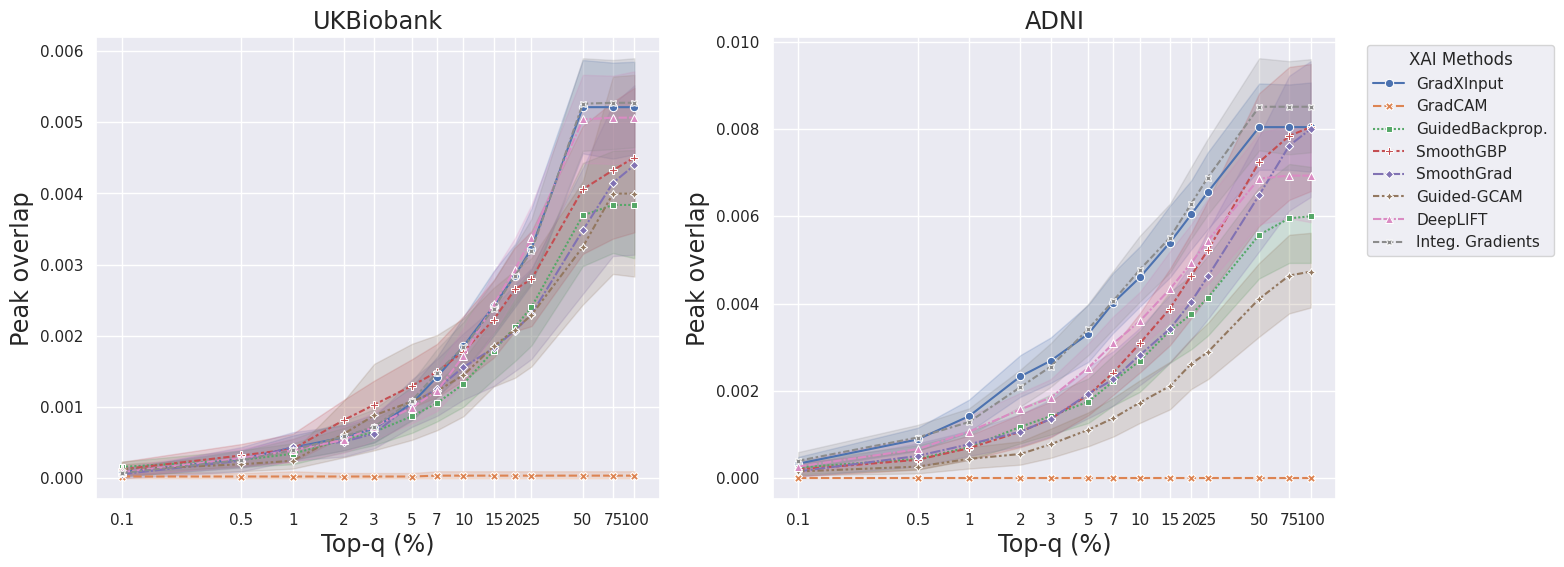

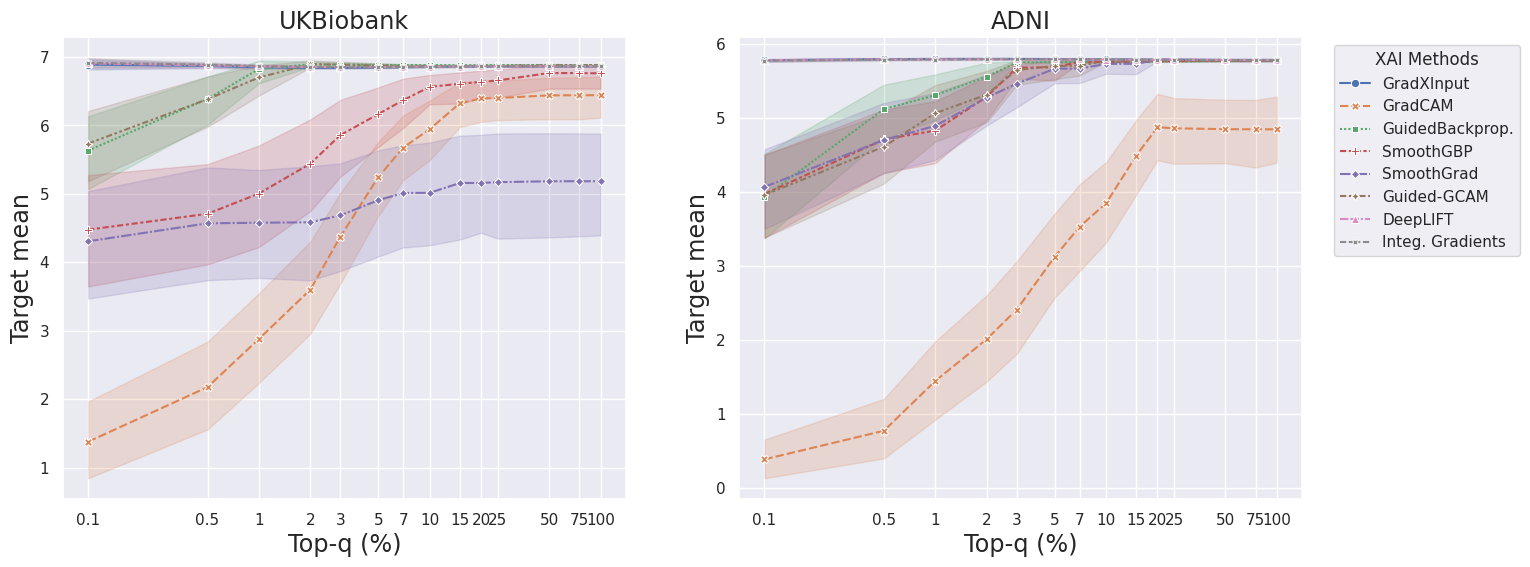

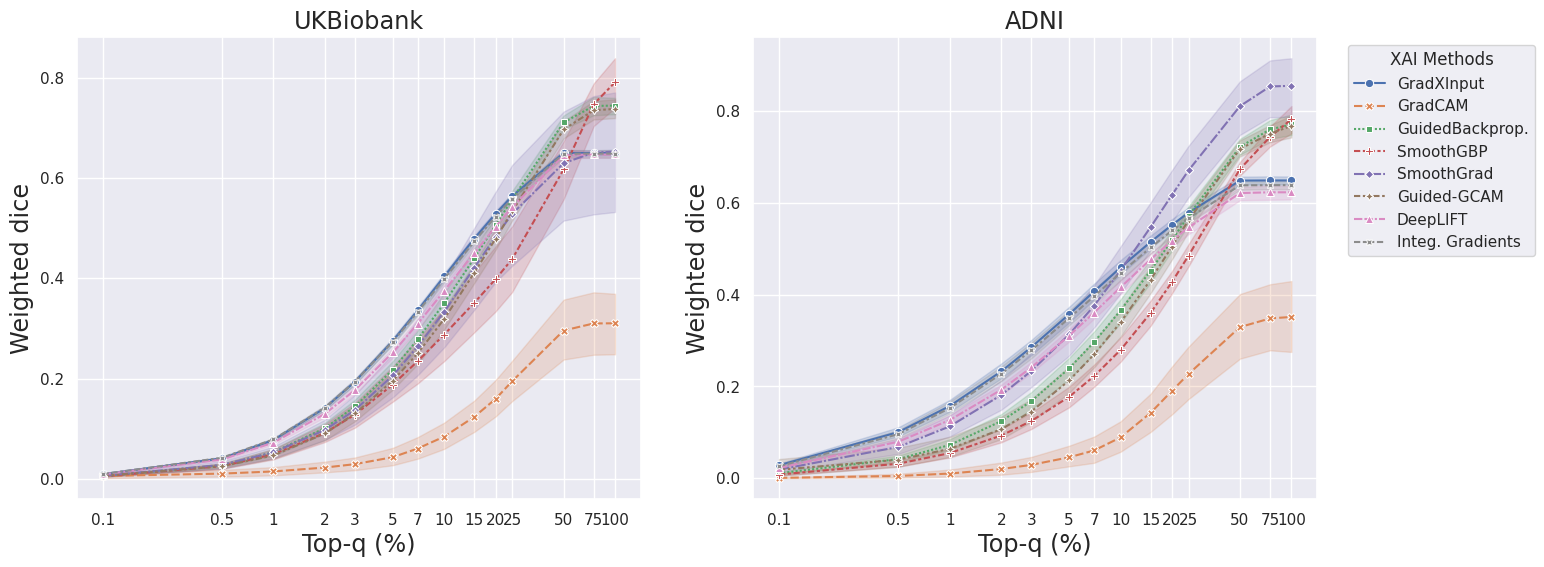

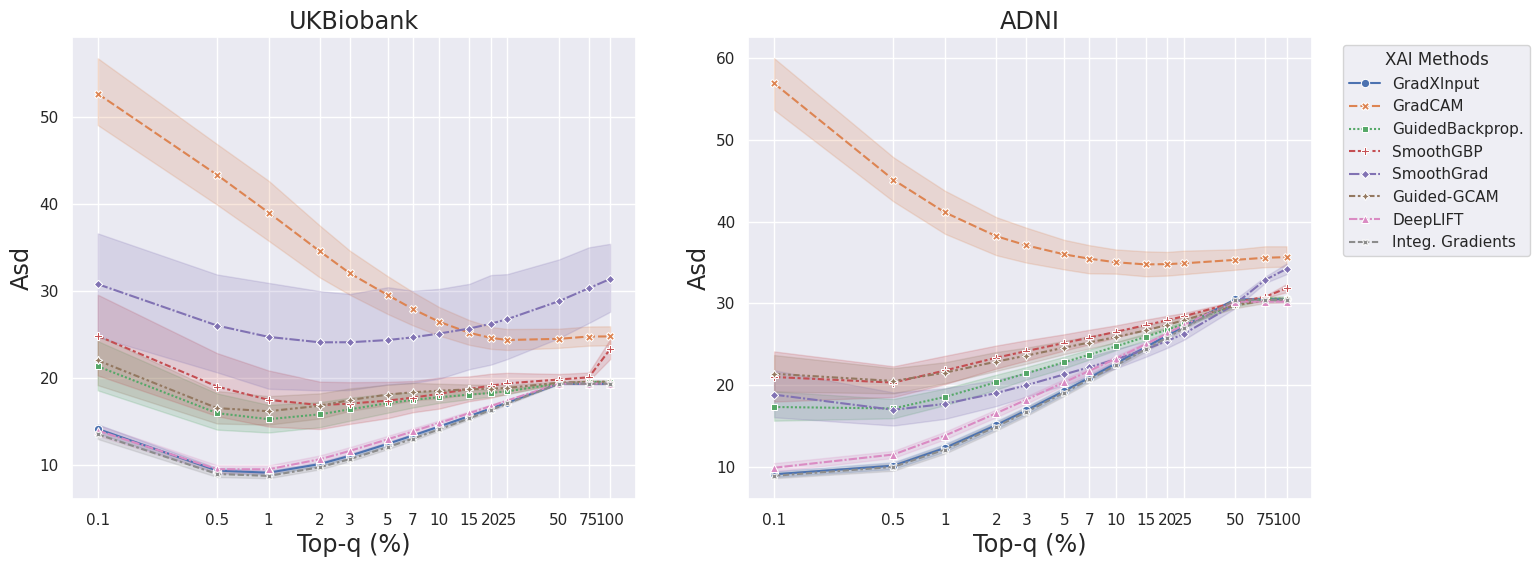

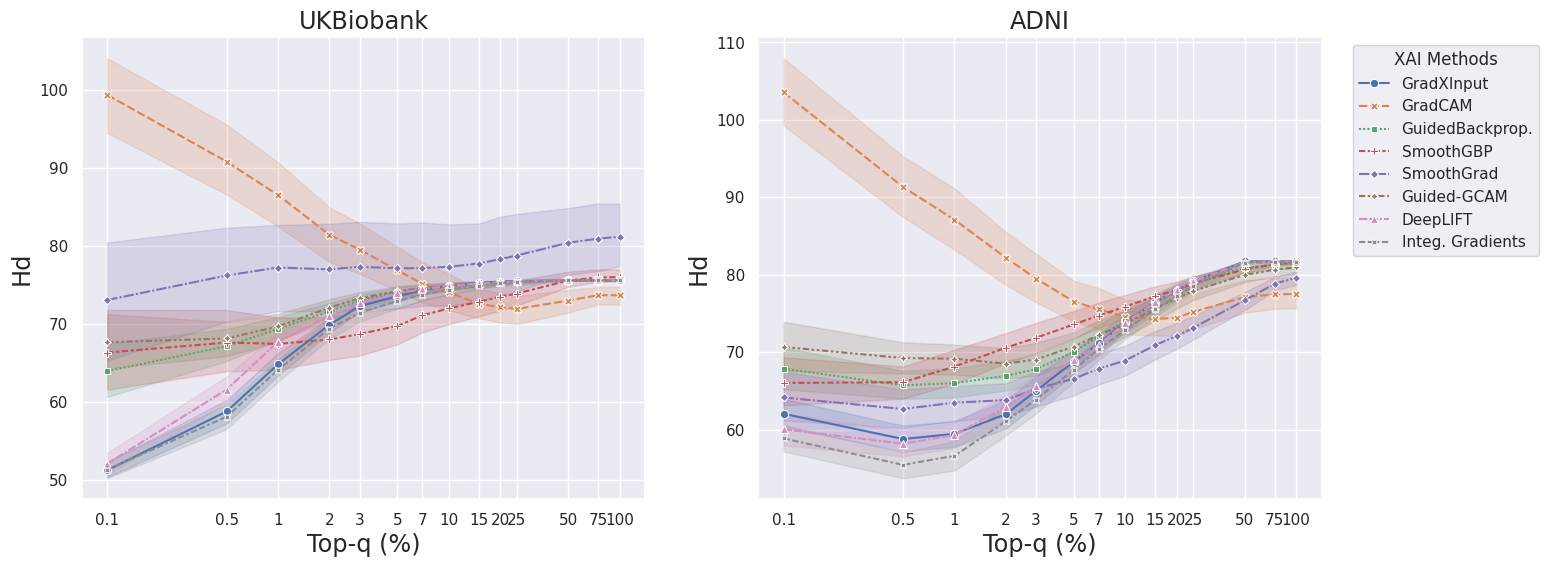

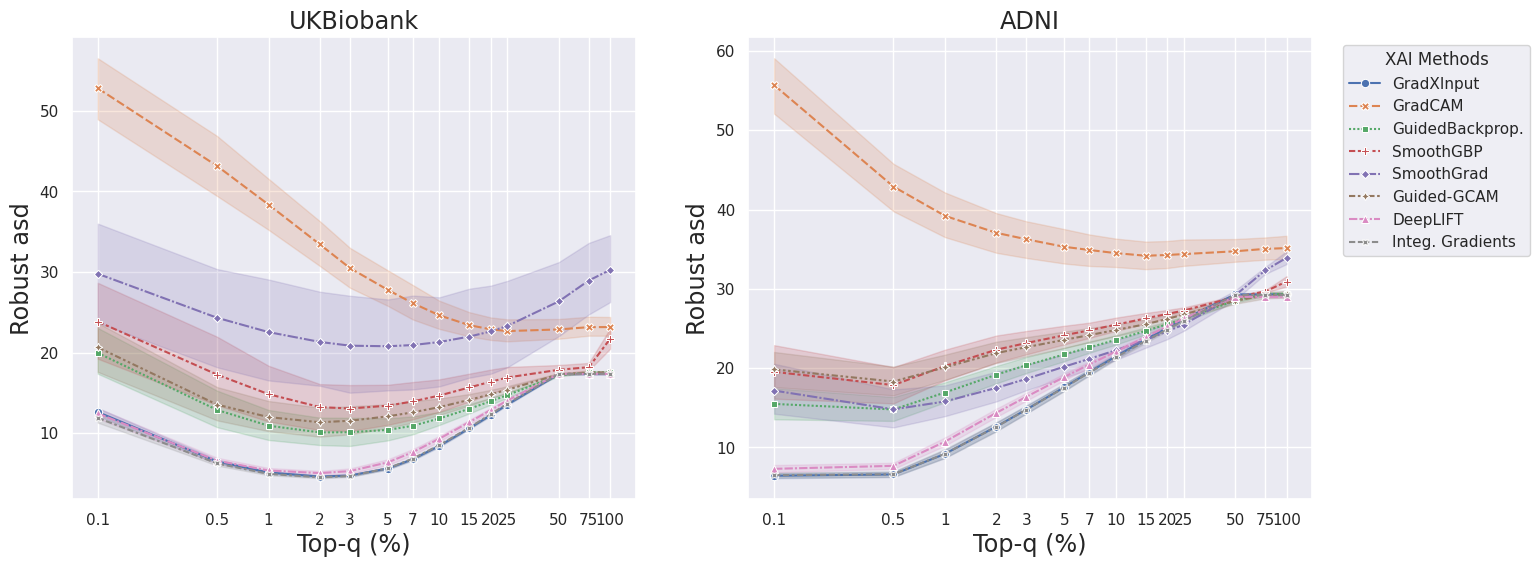

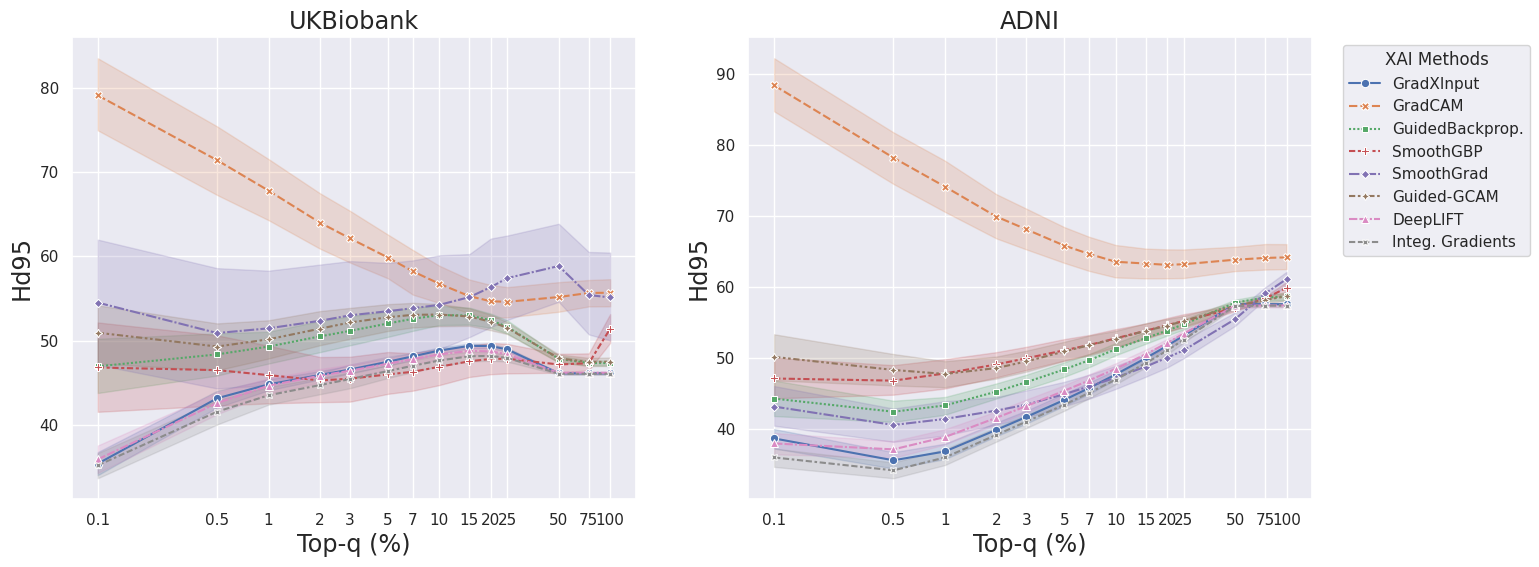

In [ ]:
for metric in attrs["gradxinput|resnet10|42"].keys():
    q_df_ukb = create_df_across_qs(attr=attrs, metric=metric)
    q_df_adni = create_df_across_qs(attr=attrs_adni, metric=metric)
    
    mn = " ".join(metric.split("_")).capitalize()
    
    # Single plot: figsize=(8, 6)
    fig, ax = plt.subplots(figsize=(16, 6), ncols=2)
    g = sns.lineplot(q_df_ukb, x="q", y=metric, hue="XAI", markers=True, style="XAI",
                     ax=ax[0], hue_order=list(C_.XAI_METHODS_MAPPER.values()))
    g.set(xscale='log')
    g.set(xticks=qs + [75, 100])
    g.set(xticklabels=qs + [75, 100])
    ax[0].set_title("UKBiobank", size="x-large")
    ax[0].set_xlabel("Top-q (%)", size="x-large")
    ax[0].set_ylabel(mn, size="x-large")
    ax[0].legend().remove()

    g = sns.lineplot(q_df_adni, x="q", y=metric, hue="XAI", markers=True, style="XAI",
                     ax=ax[1], hue_order=list(C_.XAI_METHODS_MAPPER.values()))
    g.set(xscale='log')
    g.set(xticks=qs + [75, 100])
    g.set(xticklabels=qs + [75, 100])
    ax[1].set_title("ADNI", size="x-large")
    ax[1].set_xlabel("Top-q (%)", size="x-large")
    ax[1].set_ylabel(mn, size="x-large")
    ax[1].legend(title="XAI Methods", bbox_to_anchor=(1.4, 1))

    fig.savefig(f"/home/daehyun/codespace/brain-age-prediction/RQ/media_assets/alignment_{metric}_xlog.pdf", format="pdf", dpi=100, bbox_inches='tight')
    # fig.savefig(f"/home/daehyun/codespace/brain-age-prediction/RQ/media_assets/alignment_{metric}.pdf", format="pdf", dpi=100, bbox_inches='tight')

### Statistically Significant?

In [10]:
def calculate_effect_sizes(df, dv='metric', factors=['XAI', 'Model']):
    """
    ANOVA 효과 크기(eta-squared와 partial eta-squared) 계산
    
    Parameters:
    -----------
    df : pandas DataFrame
        분석할 데이터
    dv : str
        종속 변수 (DICE 점수 등)
    factors : list
        독립 변수 리스트 (XAI, Model 등)
        
    Returns:
    --------
    pandas DataFrame
        각 요인별 효과 크기와 통계량
    """
    # 모델 수식 생성 (상호작용 포함)
    formula = f"{dv} ~ {' * '.join(factors)}"
    
    # ANOVA 모델 적합
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # 효과 크기 계산을 위한 합계 제곱합 추출
    ss_total = anova_table['sum_sq'].sum()
    
    # 결과 저장을 위한 DataFrame 생성
    results = pd.DataFrame()
    results['Source'] = anova_table.index
    results['SS'] = anova_table['sum_sq']
    results['df'] = anova_table['df']
    results['MS'] = anova_table['sum_sq'] / anova_table['df']
    results['F'] = anova_table['F']
    results['p'] = anova_table['PR(>F)']
    
    # Eta-squared 계산 (전체 변량에 대한 각 요인의 기여도)
    results['eta_sq'] = results['SS'] / ss_total
    
    # Partial eta-squared 계산 (각 요인과 오차의 합에 대한 요인의 기여도)
    results['partial_eta_sq'] = results['SS'] / (results['SS'] + anova_table.loc['Residual', 'sum_sq'])
    
    # Cohen's f 계산 (효과 크기의 또 다른 표현)
    # f = sqrt(η²/(1-η²))
    results['cohen_f'] = np.sqrt(results['partial_eta_sq'] / (1 - results['partial_eta_sq']))
    
    # Cohen's f-squared 계산
    results['cohen_f_sq'] = results['cohen_f'] ** 2
    
    # Cohen's 기준에 따른 효과 크기 해석
    def interpret_cohen_f(f):
        if f < 0.1:
            return "작음 (Small)"
        elif f < 0.25:
            return "중간 (Medium)"
        else:
            return "큼 (Large)"
    
    results['effect_size_interpretation'] = results['cohen_f'].apply(interpret_cohen_f)
    
    return results

# 함수 사용 예시
# effect_sizes = calculate_effect_sizes(df, dv='dice', factors=['XAI', 'Model'])
# print(effect_sizes)

# 추가: 집단 간 효과 크기 (Cohen's d) 계산 함수
def cohens_d_between_groups(df, dv, group_var, group1, group2):
    """
    두 집단 간 Cohen's d 효과 크기 계산
    
    Parameters:
    -----------
    df : pandas DataFrame
        분석할 데이터
    dv : str
        종속 변수 (DICE 점수 등)
    group_var : str
        집단 변수 (XAI 방법 또는 Model)
    group1, group2 : str
        비교할 두 집단의 이름
        
    Returns:
    --------
    float
        Cohen's d 값
    """
    # 두 집단 데이터 추출
    group1_data = df[df[group_var] == group1][dv]
    group2_data = df[df[group_var] == group2][dv]
    
    # 각 집단의 평균과 표준편차
    mean1, mean2 = group1_data.mean(), group2_data.mean()
    std1, std2 = group1_data.std(), group2_data.std()
    
    # 표본 크기
    n1, n2 = len(group1_data), len(group2_data)
    
    # 합동 표준편차(pooled standard deviation) 계산
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d 계산
    d = (mean1 - mean2) / pooled_std
    
    return d

# 예시: XAI 방법 간 pairwise 비교를 위한 함수
def pairwise_effect_sizes(df, dv, group_var):
    """
    모든 가능한 쌍에 대한 효과 크기 계산
    
    Parameters:
    -----------
    df : pandas DataFrame
        분석할 데이터
    dv : str
        종속 변수 (DICE 점수 등)
    group_var : str
        집단 변수 (XAI 방법 또는 Model)
        
    Returns:
    --------
    pandas DataFrame
        모든 쌍의 효과 크기
    """
    groups = df[group_var].unique()
    results = []
    
    for i, group1 in enumerate(groups):
        for group2 in groups[i+1:]:
            d = cohens_d_between_groups(df, dv, group_var, group1, group2)
            
            # 효과 크기 해석
            if abs(d) < 0.2:
                interpretation = "무시할 만함 (Negligible)"
            elif abs(d) < 0.5:
                interpretation = "작음 (Small)"
            elif abs(d) < 0.8:
                interpretation = "중간 (Medium)"
            else:
                interpretation = "큼 (Large)"
            
            results.append({
                'Group1': group1,
                'Group2': group2,
                'Cohens_d': d,
                'Interpretation': interpretation
            })
    
    return pd.DataFrame(results)

# 예시: XAI 방법 간 효과 크기 비교
# xai_effects = pairwise_effect_sizes(df, dv='dice', group_var='XAI')
# print(xai_effects.sort_values(by='Cohens_d', ascending=False))

In [11]:
xai_effects = pairwise_effect_sizes(df, dv='dice', group_var='XAI')
print(xai_effects.sort_values(by='Cohens_d', ascending=False))

         Group1       Group2  Cohens_d       Interpretation
0    gradxinput     gcam_avg  3.732747            큼 (Large)
4    gradxinput    ggcam_avg  1.371418            큼 (Large)
1    gradxinput          gbp  0.919601            큼 (Large)
2    gradxinput   smooth_gbp  0.861631            큼 (Large)
5    gradxinput     deeplift  0.578122          중간 (Medium)
3    gradxinput  smooth_grad  0.515925          중간 (Medium)
15          gbp    ggcam_avg  0.354827           작음 (Small)
22  smooth_grad    ggcam_avg  0.245894           작음 (Small)
13          gbp   smooth_gbp  0.204531           작음 (Small)
6    gradxinput           ig  0.066018  무시할 만함 (Negligible)
19   smooth_gbp    ggcam_avg  0.064050  무시할 만함 (Negligible)
14          gbp  smooth_grad -0.009529  무시할 만함 (Negligible)
18   smooth_gbp  smooth_grad -0.152033  무시할 만함 (Negligible)
23  smooth_grad     deeplift -0.285497           작음 (Small)
16          gbp     deeplift -0.492270           작음 (Small)
24  smooth_grad           ig -0.495861  

In [16]:
condition = f"{metric} ~ XAI*Model"
model = ols(condition, data=df).fit()

sm.stats.anova_lm(model, type=2)

df    sum_sq   mean_sq          F        PR(>F)
XAI          8.0  0.095615  0.011952  28.895777  1.321168e-38
Model        8.0  0.011111  0.001389   3.357831  8.825327e-04
XAI:Model   64.0  0.143021  0.002235   5.402796  1.897962e-30
Residual   646.0  0.267198  0.000414        NaN           NaN

In [17]:
df.groupby(["XAI"]).agg({metric: "mean"})

dice
XAI                  
deeplift     0.062984
gbp          0.071812
gcam_avg     0.034066
ggcam        0.057710
ggcam_avg    0.070517
gradxinput   0.062955
ig           0.063052
smooth_gbp   0.062646
smooth_grad  0.080509

In [18]:
df.groupby(["Model"]).agg({metric: "mean"})

dice
Model                   
convnext-base   0.066211
convnext-small  0.067321
convnext-tiny   0.064187
densenet121     0.061035
densenet169     0.062239
densenet264d    0.071233
resnet10        0.060624
resnet18        0.061659
resnet34        0.053150

In [109]:
df.groupby(["XAI", "Model"]).agg({metric: "mean"})

dice
XAI        Model                   
deeplift   convnext-base   0.140419
           convnext-small  0.136572
           convnext-tiny   0.139096
           densenet121     0.085849
           densenet169     0.088391
...                             ...
smooth_gbp densenet121     0.057799
           densenet169     0.000487
           resnet10        0.087823
           resnet18        0.048228
           resnet34        0.072696

[69 rows x 1 columns]